<a href="https://colab.research.google.com/github/vit050587/PyTorch/blob/master/KVA_PYTORCH_HW_10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Файл для веб-камеры (сюда грузим обученную модель)

In [2]:
!pip install facenet-pytorch==2.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from glob import glob
import sys, os

from sklearn.model_selection import train_test_split

# import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

from facenet_pytorch import MTCNN

In [4]:
# Class ResNet

def conv_block(in_channels, out_channels, pool=False):

    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))

    return nn.Sequential(*layers)

def linear_block(input_dim, output_dim, activation = False, dropout = 0.3):

    layers = [nn.Linear(input_dim, output_dim),
             nn.Dropout(dropout)]
    if activation:
        layers.append(nn.ReLU())

    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)

        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)

        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)

        self.classifier = nn.Sequential(nn.MaxPool2d(6),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)

        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)

        out = self.classifier(out)
        return out

In [6]:
# Загружаю модель, которая создана в HW_10_gcm_prepare.ipynb
gest_model = torch.load('/content/drive/MyDrive/Colab Notebooks/PyTorch/lesson10/Course_lab/gesture_classification_model.pth', map_location='cpu')
gest_model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

# Тестирование модели, только ли с камеры такое плохое распознавание?

In [7]:
images = glob('/content/drive/MyDrive/Colab Notebooks/PyTorch/lesson10/Course_lab/leapGestRecog/**/**/*.png')

In [8]:
labels = [int(os.path.basename(img).split('_')[2])-1 for img in images]

images[:3], labels[:3], len(images), len(labels)

(['/content/drive/MyDrive/Colab Notebooks/PyTorch/lesson10/Course_lab/leapGestRecog/02/01_palm/frame_02_01_0020.png',
  '/content/drive/MyDrive/Colab Notebooks/PyTorch/lesson10/Course_lab/leapGestRecog/02/01_palm/frame_02_01_0014.png',
  '/content/drive/MyDrive/Colab Notebooks/PyTorch/lesson10/Course_lab/leapGestRecog/02/01_palm/frame_02_01_0039.png'],
 [0, 0, 0],
 20000,
 20000)

In [13]:
num_name_list = [(int((os.path.split(img)[0].split('/')[-1].split('_'))[0])-1, os.path.split(img)[0].split('/')[-1].split('_')[1:]) for img in images]
num_name_dict = {}
for num, name in num_name_list:
    if num not in num_name_dict.keys():
        num_name_dict[num] = name

sorted(num_name_dict.items(), key = lambda x: x[0])

[(0, ['palm']),
 (1, ['l']),
 (2, ['fist']),
 (3, ['fist', 'moved']),
 (4, ['thumb']),
 (5, ['index']),
 (6, ['ok']),
 (7, ['palm', 'moved']),
 (8, ['c']),
 (9, ['down'])]

In [14]:
def num_to_classname(num):

    if num == 0:
        return 'palm'
    elif num == 1:
        return 'l'
    elif num == 2:
        return 'fist'
    elif num == 3:
        return 'fist_moved'
    elif num == 4:
        return 'thumb'
    elif num == 5:
        return 'index'
    elif num == 6:
        return 'ok'
    elif num == 7:
        return 'palm_moved'
    elif num == 8:
        return 'c'
    elif num == 9:
        return 'down'

In [15]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=42)

In [16]:
test_tfms =  transforms.Compose([
                         transforms.Grayscale(num_output_channels=1),
                         transforms.Resize((48,48)),
                         transforms.ToTensor()])
                         # а для теста тольуо перевод в чб и в тензор переводим

In [17]:
class GestRecogDataset(Dataset):
    def __init__(self, images_gestures, labels, transformer):
        self.images = images_gestures
        self.labels = labels
        self.transformer = transformer

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img =  Image.open(self.images[idx])
        img = self.transformer(img)

        return img, self.labels[idx]

In [18]:
batch_size = 256

# Create datasets
# train_dataset = GestRecogDataset(X_train, y_train, train_tfms)
test_dataset = GestRecogDataset(X_test, y_test, test_tfms)

# Create dataloaders
# train_loader = DataLoader(train_dataset, batch_size, shuffle = True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

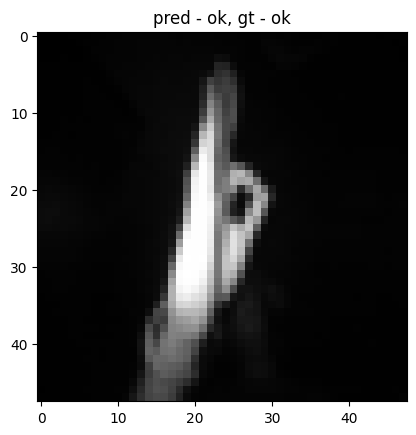

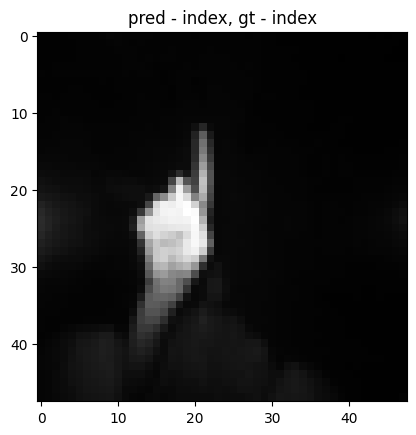

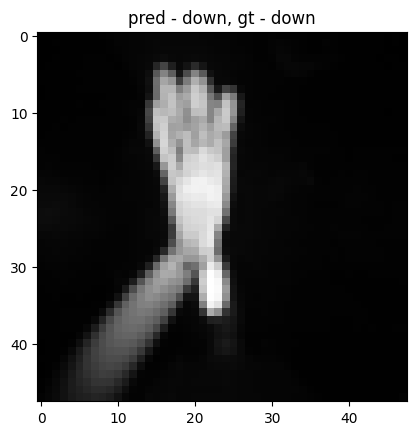

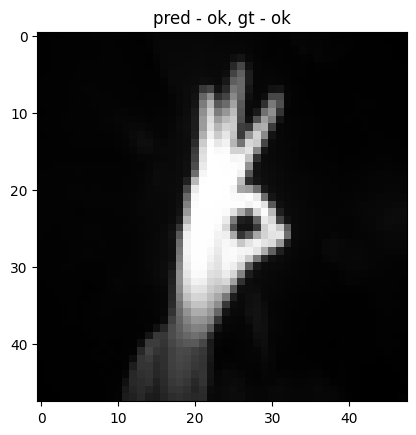

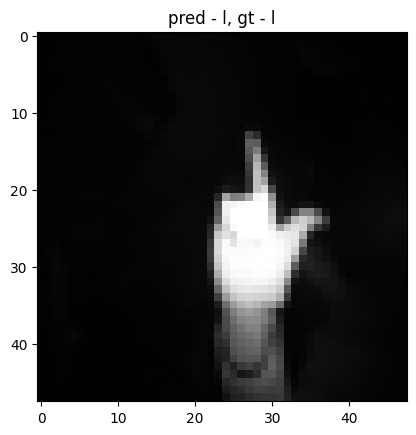

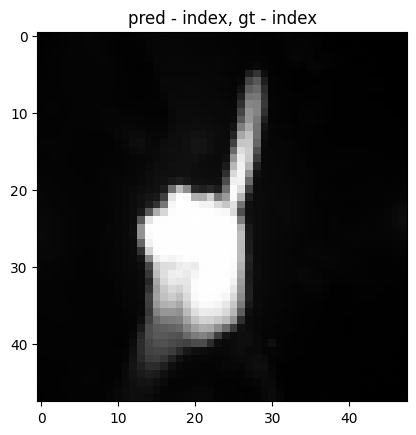

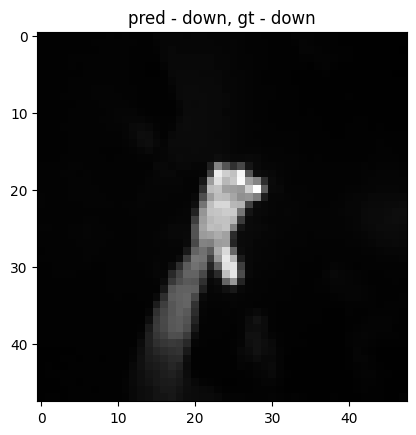

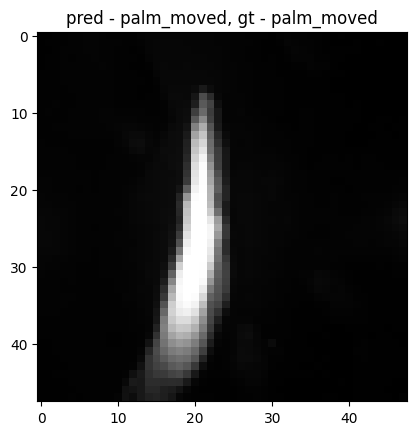

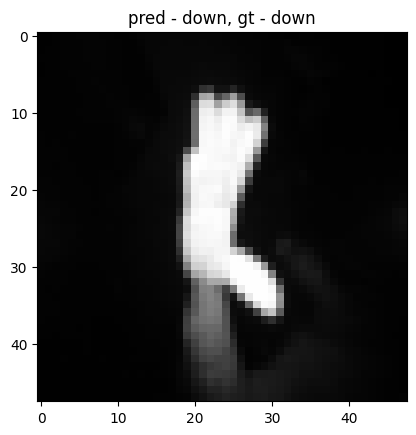

In [19]:
with torch.no_grad():
    for i, data in enumerate(test_loader, 3):
        images, labels = data[0].to('cpu'), data[1].to('cpu')

        outputs = gest_model(images)
        plt.title(f'pred - {num_to_classname(outputs[0].argmax())}, gt - {num_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break